# 多层感知机

## 数学模型

多层感知机（Multilayer Preceptron, MLP）是一种前馈人工神经网络，由输入层，至少一个隐藏层和输出层组成。每层包含若干个神经元（节点），相邻层之间全连接。

对于 $L$ 层MLP，其第 $l$ 层的表达式为：
$$
\begin{align*}
&\boldsymbol{h}^{(0)} = \boldsymbol{x}\\
&\boldsymbol{h}^{(l)} = \sigma\left(\boldsymbol{W}_i\boldsymbol{h}^{(l-1)}+\boldsymbol{b}_l\right)
\end{align*}
$$
其中 $\boldsymbol{x}\in\mathbb{R}^{d_0}$ 是输入向量，$\boldsymbol{W}_l\in\mathbb{R}^{d_l\times d_{l-1}}$ 是权重矩阵, $\boldsymbol{b}_l\in\mathbb{R}^l$ 是偏置项，$\sigma$ 是激活函数，$\boldsymbol{h}^{(l)}$ 是输出向量。

## PyTorch实战

In [1]:
import torch
import torch.nn as nn

In [2]:
# 神经网络定义
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        layer_dims = [input_dim] + hidden_dims
        for i in range(len(layer_dims)-1):
            layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]),nn.ReLU()])
        layers.extend([nn.Linear(layer_dims[-1], output_dim)])

        self.fwd = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.fwd(x)

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
# 加载训练数据
digits = load_digits()
X, y = digits.data, digits.target
print(X.shape, y.dtype)
print(y.shape, y.dtype)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 转化为PyTorch张量
X_train, X_test = [torch.tensor(data, dtype=torch.float32) for data in [X_train, X_test]]
y_train, y_test = [torch.tensor(data, dtype=torch.long) for data in [y_train, y_test]]

(1797, 64) int64
(1797,) int64


In [5]:
# 模型定义
model = MLP(input_dim=X_train.shape[1], hidden_dims=[128, 128, 128], output_dim=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [6]:
# 模型训练
epochs = 1000
batch_size = 200
losses = []

model.train()
for epoch in range(epochs):
    indices = torch.randperm(X_train.shape[0])
    for i in range(0, X_train.shape[0], batch_size):
        
        optimizer.zero_grad()
        batch_X, batch_y = X_train[indices[i:i+batch_size],:], y_train[indices[i:i+batch_size]]
        loss = loss_fn(model(batch_X), batch_y)

        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:03d}; Loss {loss:.6e}")

# 模型验证
model.eval()
with torch.no_grad():
    acc = (model(X_test).argmax(1) == y_test).float().mean().item()
    print(f"Test accuracy {acc:.6e}")

Epoch 000; Loss 2.177408e+00
Epoch 100; Loss 1.541651e-04
Epoch 200; Loss 5.544011e-05
Epoch 300; Loss 2.053767e-05
Epoch 400; Loss 2.792667e-05
Epoch 500; Loss 8.229370e-05
Epoch 600; Loss 3.076924e-05
Epoch 700; Loss 3.854926e-05
Epoch 800; Loss 2.848289e-05
Epoch 900; Loss 5.241362e-05
Test accuracy 9.805555e-01


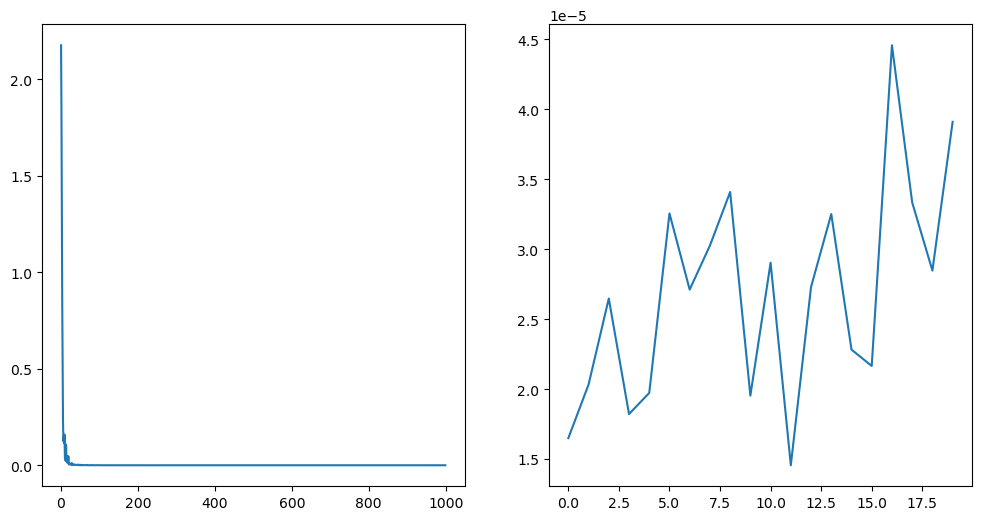

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(losses)
plt.subplot(1,2,2)
plt.plot(losses[-20:])
plt.show()